In [122]:
"""
废弃！！！！
这个CurLink是尝试在train_test_split_edges_m中考虑新产生的社交链接，让负样本不包含新链接
该方法不科学，但可能会有更好的效果
"""
# 为了方便GAT训练，这里把用户的id都-1，让id从0开始
import pickle
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling,to_undirected
import heapq
import random
from GATmodel import GATNet
from torch_geometric.data import Data

# 转换lable
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

# 读取数据
def get_data(city):
    with open('data_proces/'+ city +'data_heterHyper.pickle', 'rb') as file:
        data_social = pickle.load(file)

    friendship_new_df = data_social['friendship_new_df']
    friendship_old_df = data_social['friendship_old_df']
    checkins_df = data_social['checkins_df']
    All_N_O_list_list = data_social['All_N_O_list_list']
    All_O_N_list_list = data_social['All_O_N_list_list']
    hyperBip_id_vec_list = data_social['hyperBip_id_vec_list']
    social_id_vec_list = data_social['social_id_vec_list']
    HeterHyper_id_vec_list = data_social['HeterHyper_id_vec_list']

    # 为了方便GAT训练，这里把用户的id都-1，让id从0开始
    hyperBip_id_vec_list.pop(0)
    social_id_vec_list.pop(0)
    HeterHyper_id_vec_list.pop(0)
    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    return friendship_new_df, friendship_old_df, checkins_df, All_N_O_list_list, All_O_N_list_list, hyperBip_id_vec_list, social_id_vec_list, HeterHyper_id_vec_list

# GAT训练函数
def train(data, model, optimizer):
    model.train()

    # 进行节点负采样 正负样本1:nn
    nn = 10
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1) * nn)

    # train_neg_edge_set = set(map(tuple, neg_edge_index.T.tolist()))
    # val_pos_edge_set = set(map(tuple, data.val_pos_edge_index.T.tolist()))
    # test_pos_edge_set = set(map(tuple, data.test_pos_edge_index.T.tolist()))
    #     if (len(train_neg_edge_set & val_pos_edge_set) > 0) or (len(train_neg_edge_set & test_pos_edge_set) > 0):
    #         # 训练集负样本与验证集负样本存在交集，或训练集负样本与测试集负样本存在交集
    #         print('wrong!')

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

# 课程学习的训练函数
def train_diff(data, model, optimizer, nowDiff):
    model.train()

    # 进行节点负采样 正负样本1:nn
    nn = 10
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_Diff_pos_edge_index[nowDiff].size(1) * nn)

    # num_neg_samples = data.train_Diff_pos_edge_index[nowDiff].size(1) * nn #采样个数
    # neg_row, neg_col = data.train_neg_edge_index
    # perm = torch.randperm(neg_row.size(0))
    # neg_row, neg_col = neg_row[perm][:num_neg_samples], neg_col[perm][:num_neg_samples]
    # neg_edge_index = torch.stack([neg_row, neg_col], dim=0)

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_Diff_pos_edge_index[nowDiff])
    link_logits = model.decode(z, data.train_Diff_pos_edge_index[nowDiff], neg_edge_index)
    link_labels = get_link_labels(data.train_Diff_pos_edge_index[nowDiff], neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

# 定义单个epoch验证过程
@torch.no_grad()
def val(data, model):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    prefix = 'val'
    pos_edge_index = data[f'{prefix}_pos_edge_index']
    neg_edge_index = data[f'{prefix}_neg_edge_index']
    link_logits = model.decode(z, pos_edge_index, neg_edge_index)
    link_probs = link_logits.sigmoid()
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)
    return roc_auc_score(link_labels.cpu(), link_probs.cpu())

# # 余弦距离
# def countCos(x, y):
#     return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# 计算余弦相似度
def cosinematrix(A):
    prod = torch.mm(A, A.t())  # 分子
    norm = torch.norm(A, p=2, dim=1).unsqueeze(0)  # 分母
    cos = prod.div(torch.mm(norm.t(), norm))
    return cos

# 计算sigmoid
def countSigmoid(x_list):
    sig_x = []
    for x in x_list:
        sig_x.append(1 / (1 + math.exp(-x)))
    return sig_x

# 用来给数据分训练集验证集(测试集用新的社交链接）
def train_test_split_edges_m(data, val_ratio, neg_candidates_num):
    """
    val_ratio:验证集比例
    test_ratio：测试集比例
    val_neg_ratio:验证集负样本比例
    test_neg_candidates_num：测试集负样本数量（SOTA为50）
    """
    num_nodes = data.num_nodes
    row, col = data.edge_index
    row_all, col_all = data.edge_new_index # 新旧社交链接
    mask = row < col
    row, col = row[mask], col[mask]
    n_v = int(math.floor(val_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v :], col[n_v :]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)

    # Negative edges.
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row_all, col_all] = 0

    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))
    neg_row, neg_col = neg_row[perm], neg_col[perm]
    # data.train_neg_edge_index = torch.stack([neg_row, neg_col], dim=0) # 训练负采样的样本

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    """
    采样验证集的负样本 按照负样本的候选用户数量进行采样
    """
    val_user_list = list(set(data.val_pos_edge_index[0]) | set(data.val_pos_edge_index[1]))  # 先得到test中的用户list

    # 只有val中的节点未连接的为1
    neg_adj_mask = torch.zeros(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    for ii in range(len(val_user_list)):
        for jj in range(len(val_user_list)):
            if (jj <= ii): continue
            neg_adj_mask[val_user_list[ii]][val_user_list[jj]] = 1
            neg_adj_mask[val_user_list[jj]][val_user_list[ii]] = 1
    row, col = data.val_pos_edge_index
    neg_adj_mask[row, col] = 0  # val中有连接的为0
    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    # 随机采样，大概是每个用户取test_neg_candidates_num(50)个候选
    row = neg_row[:n_v * neg_candidates_num]
    col = neg_col[:n_v * neg_candidates_num]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    return data

# 用来给数据进行难度分级
def train_Diff_split_edges(data, node_diff_list, NUM_diff_leve):
    num_nodes = data.num_nodes
    row, col = data.train_pos_edge_index

    data.train_Diff_pos_edge_index = []
    for i in range(NUM_diff_leve):
        data.train_Diff_pos_edge_index.append([[], []])  # 每一个难度等级有一对列表

    for e1, e2 in zip(row, col):
        # 假设GAT里边的方向是(a,b) a->b
        diff_index = node_diff_list.index(int(e2))
        now_node_diff = int(diff_index * NUM_diff_leve / num_nodes)

        for ii in range(now_node_diff, NUM_diff_leve): # 大于等于该难度等级的课程都有该节点数据
            data.train_Diff_pos_edge_index[ii][0].append(e1)
            data.train_Diff_pos_edge_index[ii][1].append(e2)


    for i in range(NUM_diff_leve):
        data.train_Diff_pos_edge_index[i] = torch.tensor(data.train_Diff_pos_edge_index[i], dtype=torch.long)
    return data

# 计算count_o2n_Acc_Recall中需要的link_new_labels_M，目的是为了保证计算各方法的结果时负采样一致
def count_link_lables(num_user, friendship_new_df, friendship_old_df,neg_num):
    # # 社交网络邻接矩阵 考虑id从1开始
    link_new_labels_M = np.zeros((num_user, num_user))
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        link_new_labels_M[uid1][uid2] = 1
        link_new_labels_M[uid2][uid1] = 1
    # 旧社交网络邻接矩阵
    for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
        link_new_labels_M[uid1][uid2] = 2  # 原new的社交链接中实际上是old+新增的社交链接，所以这里将新增社交链接中的旧链接去掉，防止影响后面预测（特别是召回率分母）
        link_new_labels_M[uid2][uid1] = 2
    # # 进行负采样，只让采样上的为3，其他为0
    # for link_u_new_l in link_new_labels_M:
    #     tensor_link_u_new_l = torch.tensor(link_u_new_l)
    #     pre_ind = torch.eq(tensor_link_u_new_l, 0).nonzero().numpy().tolist()
    #     for preI in random.sample(pre_ind, neg_num):# 负样本随机抽取neg_num(50)个
    #         link_u_new_l[preI[0]] = 3
    return link_new_labels_M

# 计算accuracy，recall计算,考虑旧的社交链接问题
def count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M):
    P_K_list = []
    R_K_list = []
    # 计算精确度和召回率

    # 对每个user进行计算  这是以前的计算方法，目的是仅采样一部分负样本
    prob_adj = prob_adj.detach().numpy()
    for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
        # 只对正样本和抽取的负样本进行预测
        tensor_link_u_new_l = torch.tensor(link_u_new_l)
        pre_ind = torch.eq(tensor_link_u_new_l, 1).nonzero().numpy().tolist()
        for preI in pre_ind:
            link_u_p[preI[0]] += 1000  # 正样本全参与预测
        pre_ind = torch.eq(tensor_link_u_new_l, 0).nonzero().numpy().tolist()
        for preI in pre_ind:
            link_u_p[preI[0]] += 1000  # 抽取的负样本参与预测

        link_u_p = list(link_u_p)  # ndarray 转 list
        link_u_l = list(link_u_new_l)
        num_1 = list(link_u_l).count(1)  # 该用户新增的链接个数
        if (num_1 < 1):
            continue
        max_num_index_list = list(map(link_u_p.index, heapq.nlargest(K, link_u_p)))
        N_u_true = 0
        for index in max_num_index_list:
            if link_u_l[index] == 1:
                N_u_true += 1

        P_K_list.append(N_u_true / K)
        R_K_list.append(N_u_true / num_1)

#     # 在全局中进行预测
#     for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
#         link_u_l = list(link_u_new_l)
#         num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
#         if num_1 == 0:  # 该用户没有新的社交链接 则跳过
#             continue
#         # 只对正样本和抽取的负样本进行预测
#         sort_enu = sorted(enumerate(link_u_p.detach().numpy()), key=lambda link_u_p: link_u_p[1], reverse=True)
#         sort_index = [x[0] for x in sort_enu]  # 得到从大到小排序后的坐标
    
#         tmpK = 0
#         N_u_true = 0
#         for index in sort_index:
#             if link_u_new_l[index] == 2: #旧的社交链接不参与预测
#                 continue
#             if link_u_new_l[index] == 1:
#                 N_u_true += 1
#             tmpK += 1
#             if tmpK == K:
#                 break
    
#         P_K_list.append(N_u_true / K)
#         R_K_list.append(N_u_true / num_1)

    P_ = sum(P_K_list) / len(P_K_list)
    R_ = sum(R_K_list) / len(R_K_list)
    if P_ + R_ != 0:
        F1_ = 2 * (P_ * R_) / (P_ + R_)
    else:
        F1_ = 0

    return P_, R_, F1_

# 计算节点难度 返回的是按节点难度从小到大排序的节点id
def count_diff_of_nodes(num_u, R_ball, userVec, friendship_df):
    # 计算各节点间距离  节点id从0开始
    disCos_M = 1 - cosinematrix(torch.tensor(np.array(userVec)))
    for i in range(len(disCos_M)):
        disCos_M[i][i] = 3 # 自己和自己的余弦距离大一点
    disCos_M_minR_mask = disCos_M < R_ball
    disCos_M_minR_mask = disCos_M_minR_mask.detach().numpy()

    # 存储是否有链接的矩阵
    SN_link_M = np.zeros((num_u, num_u))
    for e1, e2 in zip(friendship_df['uid1'], friendship_df['uid2']):
        SN_link_M[e1][e2] = 1
        SN_link_M[e2][e1] = 1

    diff_node_list = []  # 节点的计算难度
    num_inBall_list = []
    for index_ii in range(num_u):
        count_num = 0  # 计算球体内节点总数
        count_inR_link = 0  # 计算球体内有链接的节点数
        for index_jj in range(num_u):
            if disCos_M_minR_mask[index_ii][index_jj]:
                count_num += 1
                if SN_link_M[index_ii][index_jj] == 1:
                    count_inR_link += 1
        count_diff = 0
        if (count_num > 0):
            count_diff = count_inR_link / count_num
        diff_node_list.append(1 - count_diff)  # 数字越大难度越大
        num_inBall_list.append(count_num)  ##

    node_And_diff_list = [(i, diff_node_list[i]) for i in range(num_u)]
    node_And_diff_list.sort(key=lambda x: x[1])
    node_diffASC_list = [node_And_diff_list[i][0] for i in range(num_u)]

    # print("半径内平均个节点数：", sum(num_inBall_list) / len(num_inBall_list))
    # print("平均学习难度：", sum(diff_node_list) / len(diff_node_list))
    return node_diffASC_list

# 绘制曲线的函数
def drawLossVal(x,y,labelName,picName,x_lable,y_lable):
    fig, ax_loss = plt.subplots(figsize=(12, 7))
    # 绘制曲线
    ax_loss.plot(x, y, "r-", linewidth=2.0, label=labelName)
    # 添加样式
    ax_loss.set_title(picName, fontdict={"fontsize": 25})  # 标题
    ax_loss.set_xlabel(x_lable)  # 添加横轴标签
    ax_loss.set_ylabel(y_lable)  # 添加纵轴标签
    ax_loss.legend(loc="best", fontsize=16)  # 展示图例
    plt.grid(True)

city = "SaoPaulo"
print("*" * 20, "开始处理" + city + "的数据", "*" * 20)
# 读取数据
print("-" * 10, "读取" + city + "原数据", "-" * 10)
# 读取的是已经重新编排ID的数据，且id从0开始
friendship_new_df, friendship_old_df, checkins_df, All_N_O_list_list, All_O_N_list_list, hyperBip_id_vec_list, \
social_id_vec_list, HeterHyper_id_vec_list = get_data(city)

num_u = len(All_N_O_list_list[0]) - 1  # 用户数量 -1因为考虑了id从0开始
link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, 50)

******************** 开始处理SaoPaulo的数据 ********************
---------- 读取SaoPaulo原数据 ----------


# 仅GAT

In [110]:
# 构建训练的data
x_GAT = []
for _ in range(num_u):
    tmp_arr = np.random.rand(3000)
    x_GAT.append(list(tmp_arr))
x_curLink = torch.tensor(x_GAT, dtype=torch.float32)
edge_index = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index[0].append(uid1)
    edge_index[1].append(uid2)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_new_index = [[], []]
for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
    edge_new_index[0].append(uid1)
    edge_new_index[1].append(uid2)
edge_new_index = torch.tensor(edge_new_index, dtype=torch.long)
data = Data(x=x_curLink, edge_index=edge_index, edge_new_index=edge_new_index)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
ground_truth_edge_index = data.edge_index.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, val_ratio=0.1, neg_candidates_num=int(num_u * 0.1))
# data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

x_epoch = []
y_loss = []
y_val_auc = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
for epoch in range(1, num_epoch + 1):
    loss = train(data, model, optimizer)
    val_auc = val(data, model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}')
    x_epoch.append(epoch)
    y_loss.append(float(loss))
    y_val_auc.append(float(val_auc))

    # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
    if len(y_val_auc) > num_fit:
        fit_y = np.array(y_val_auc[-num_fit:])
        f1 = np.polyfit(fit_x, fit_y, 1)
        if f1[0] <= 0: break

# print("  ")
# print("result：")
# print("loss:", y_loss[-1])
# print("val_auc:", y_val_auc[-1])
zzz = model.encode(data.x, data.train_pos_edge_index)
prob_adj = zzz @ zzz.t()
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0

K = 10
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1_：", F1_)

"""
绘制曲线
"""
x_epoch = [i + 1 for i in range(len(y_val_auc))]
loss曲线
drawLossVal(x_epoch, y_loss, "loss", "LOSS_Experiment", "epoch", "auc")

# auc曲线
drawLossVal(x_epoch, y_val_auc, "val", "val_Experiment", "epoch", "val")

Epoch: 001, Loss: 22.0439, Val: 0.5380
Epoch: 002, Loss: 7.4188, Val: 0.5805
Epoch: 003, Loss: 2.4605, Val: 0.5931
Epoch: 004, Loss: 2.3064, Val: 0.5769
Epoch: 005, Loss: 3.0687, Val: 0.5700
Epoch: 006, Loss: 3.2775, Val: 0.5707
Epoch: 007, Loss: 2.9263, Val: 0.5807
Epoch: 008, Loss: 2.3814, Val: 0.5965
Epoch: 009, Loss: 1.8780, Val: 0.6060
Epoch: 010, Loss: 1.5500, Val: 0.6046
Epoch: 011, Loss: 1.3854, Val: 0.6028
Epoch: 012, Loss: 1.3292, Val: 0.6042
Epoch: 013, Loss: 1.3041, Val: 0.6085
Epoch: 014, Loss: 1.2443, Val: 0.6117
Epoch: 015, Loss: 1.1480, Val: 0.6158
Epoch: 016, Loss: 1.0421, Val: 0.6191
Epoch: 017, Loss: 0.9552, Val: 0.6215
Epoch: 018, Loss: 0.8990, Val: 0.6234
Epoch: 019, Loss: 0.8709, Val: 0.6244
Epoch: 020, Loss: 0.8601, Val: 0.6243
Epoch: 021, Loss: 0.8572, Val: 0.6231
Epoch: 022, Loss: 0.8547, Val: 0.6219
Epoch: 023, Loss: 0.8489, Val: 0.6214
Epoch: 024, Loss: 0.8420, Val: 0.6222
Epoch: 025, Loss: 0.8334, Val: 0.6237
Epoch: 026, Loss: 0.8225, Val: 0.6264
Epoch: 027,

NameError: name 'loss曲线' is not defined

# CurLink

In [13]:
# curLink
print("-" * 10, "开始计算CurLink", "-" * 10)
R_ball = 0.5  # 超球体半径参数


print("-" * 10, "计算user的学习困难程度", "-" * 10)
# 首先计算user的学习困难程度
node_diffASC_list = count_diff_of_nodes(num_u, R_ball, HeterHyper_id_vec_list, friendship_old_df)

---------- 开始计算CurLink ----------
---------- 计算user的学习困难程度 ----------


In [14]:
# 构建训练的data
NUM_diff_leve = 15  # 学习难度等级总数
num_epoch = 1000 # 学习epoch数
x_curLink = torch.tensor(HeterHyper_id_vec_list, dtype=torch.float32)
edge_index = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index[0].append(uid1)
    edge_index[1].append(uid2)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_new_index = [[], []]
for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
    edge_new_index[0].append(uid1)
    edge_new_index[1].append(uid2)
edge_new_index = torch.tensor(edge_new_index, dtype=torch.long)
data = Data(x=x_curLink, edge_index=edge_index, edge_new_index=edge_new_index)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
ground_truth_edge_index = data.edge_index.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, val_ratio=0.1, neg_candidates_num=int(num_u * 0.1))
#data = train_test_split_edges_m(data, val_ratio=0.1, neg_candidates_num=50)
data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

/tmp/ipykernel_82379/2246033257.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x_curLink = torch.tensor(HeterHyper_id_vec_list, dtype=torch.float32)


---------- CurLink(GAT)开始训练 ----------
*********
训练新的难度等级
*********
diffLevel:1,Epoch: 001, Loss: 1.2488, Val: 0.6647,
diffLevel:1,Epoch: 002, Loss: 1.1872, Val: 0.6804,
diffLevel:1,Epoch: 003, Loss: 1.1348, Val: 0.6967,
diffLevel:1,Epoch: 004, Loss: 1.0847, Val: 0.7132,
diffLevel:1,Epoch: 005, Loss: 1.0403, Val: 0.7297,
diffLevel:1,Epoch: 006, Loss: 0.9995, Val: 0.7461,
diffLevel:1,Epoch: 007, Loss: 0.9637, Val: 0.7621,
diffLevel:1,Epoch: 008, Loss: 0.9316, Val: 0.7775,
diffLevel:1,Epoch: 009, Loss: 0.9027, Val: 0.7920,
diffLevel:1,Epoch: 010, Loss: 0.8788, Val: 0.8057,
diffLevel:1,Epoch: 011, Loss: 0.8550, Val: 0.8184,
diffLevel:1,Epoch: 012, Loss: 0.8347, Val: 0.8300,
diffLevel:1,Epoch: 013, Loss: 0.8140, Val: 0.8405,
diffLevel:1,Epoch: 014, Loss: 0.8011, Val: 0.8500,
diffLevel:1,Epoch: 015, Loss: 0.7850, Val: 0.8585,
diffLevel:1,Epoch: 016, Loss: 0.7727, Val: 0.8660,
diffLevel:1,Epoch: 017, Loss: 0.7628, Val: 0.8727,
diffLevel:1,Epoch: 018, Loss: 0.7539, Val: 0.8785,
diffLevel:1,Ep

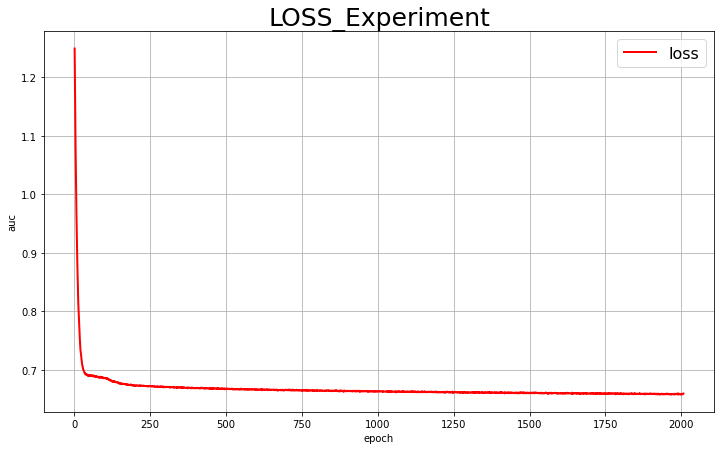

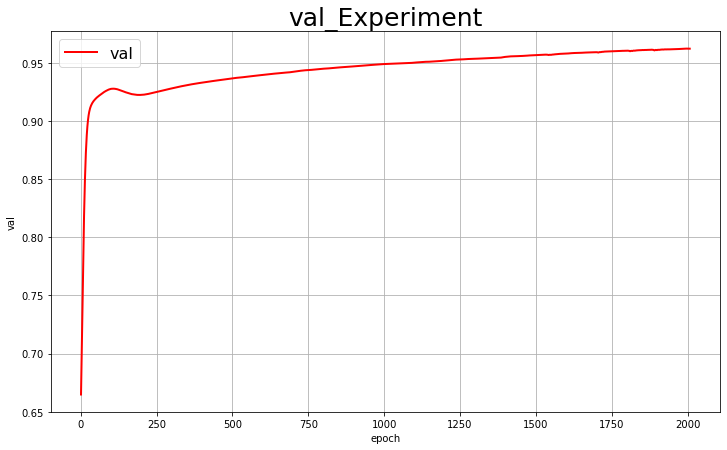

In [15]:
print("-" * 10, "CurLink(GAT)开始训练", "-" * 10)

# 构建网络开始训练
# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# 训练
y_loss = []
y_val_auc = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
for nowDiff in range(NUM_diff_leve):
    print("*********\n训练新的难度等级\n*********")
    y_tmp_val_auc = []
    for epoch in range(1, num_epoch+1):
        loss = train_diff(data, model, optimizer, nowDiff)
        val_auc = val(data, model)
        print(f'diffLevel:{nowDiff+1},Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f},')
        y_loss.append(float(loss))
        y_val_auc.append(float(val_auc))
        y_tmp_val_auc.append(float(val_auc))

        # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
        if len(y_tmp_val_auc) > num_fit:
            fit_y = np.array(y_val_auc[-num_fit:])
            f1 = np.polyfit(fit_x, fit_y, 1)
            if f1[0] <= 0: 
                print(f'diffLevel:{nowDiff+1},Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f},')
                break

print("  ")
print("result：")
print("loss:", y_loss[-1])
print("val_auc:", y_val_auc[-1])
zzz = model.encode(data.x, data.train_pos_edge_index)
prob_adj = zzz @ zzz.t()
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0  # 自己和自己的距离小

K = 10  # topk
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1：", F1)

x_epoch = [i + 1 for i in range(len(y_val_auc))]
drawLossVal(x_epoch, y_loss, "loss", "LOSS_Experiment", "epoch", "auc")
drawLossVal(x_epoch, y_val_auc, "val", "val_Experiment", "epoch", "val")

# 异构超图+GAT

Epoch: 001, Loss: 1.0886, Val: 0.6615
Epoch: 002, Loss: 1.0440, Val: 0.6774
Epoch: 003, Loss: 1.0027, Val: 0.6938
Epoch: 004, Loss: 0.9675, Val: 0.7105
Epoch: 005, Loss: 0.9335, Val: 0.7272
Epoch: 006, Loss: 0.9048, Val: 0.7438
Epoch: 007, Loss: 0.8777, Val: 0.7599
Epoch: 008, Loss: 0.8532, Val: 0.7753
Epoch: 009, Loss: 0.8316, Val: 0.7898
Epoch: 010, Loss: 0.8131, Val: 0.8033
Epoch: 011, Loss: 0.7957, Val: 0.8158
Epoch: 012, Loss: 0.7801, Val: 0.8271
Epoch: 013, Loss: 0.7672, Val: 0.8373
Epoch: 014, Loss: 0.7553, Val: 0.8464
Epoch: 015, Loss: 0.7442, Val: 0.8545
Epoch: 016, Loss: 0.7352, Val: 0.8616
Epoch: 017, Loss: 0.7271, Val: 0.8679
Epoch: 018, Loss: 0.7202, Val: 0.8733
Epoch: 019, Loss: 0.7137, Val: 0.8780
Epoch: 020, Loss: 0.7082, Val: 0.8820
Epoch: 021, Loss: 0.7038, Val: 0.8855
Epoch: 022, Loss: 0.6993, Val: 0.8885
Epoch: 023, Loss: 0.6962, Val: 0.8911
Epoch: 024, Loss: 0.6929, Val: 0.8933
Epoch: 025, Loss: 0.6906, Val: 0.8952
Epoch: 026, Loss: 0.6883, Val: 0.8969
Epoch: 027, 

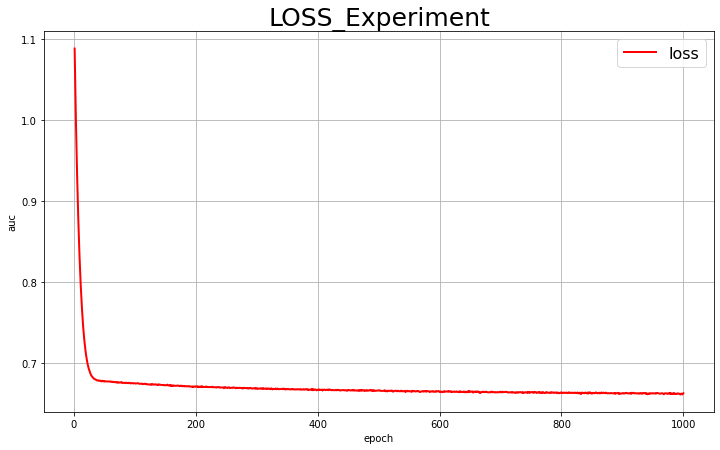

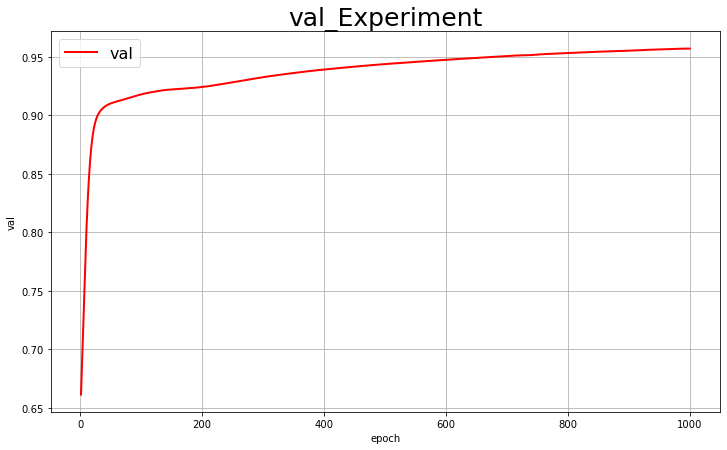

In [49]:
# 构建训练的data
x_curLink = torch.tensor(HeterHyper_id_vec_list, dtype=torch.float32)
edge_index = [[], []]
for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
    edge_index[0].append(uid1)
    edge_index[1].append(uid2)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_new_index = [[], []]
for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
    edge_new_index[0].append(uid1)
    edge_new_index[1].append(uid2)
edge_new_index = torch.tensor(edge_new_index, dtype=torch.long)
data = Data(x=x_curLink, edge_index=edge_index, edge_new_index=edge_new_index)  # 构建data

# 网络数据放入GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU
ground_truth_edge_index = data.edge_index.to(device)  # 数据放入GPU
# 样本负采样,测试集验证集分裂,按学习难度分化数据集
data = train_test_split_edges_m(data, val_ratio=0.1, neg_candidates_num=int(num_u * 0.1))
# data = train_Diff_split_edges(data, node_diffASC_list, NUM_diff_leve)  # 根据学习难度，对边数据进行分级
data = data.to(device)  # 将数据放入device

# 构建网络
num_node_features = len(data.x[0])
model = GATNet(num_node_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

x_epoch = []
y_loss = []
y_val_auc = []
num_fit = 10
fit_x = np.array([i + 1 for i in range(num_fit)])
for epoch in range(1, 1000+1):
    loss = train(data, model, optimizer)
    val_auc = val(data, model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}')
    x_epoch.append(epoch)
    y_loss.append(float(loss))
    y_val_auc.append(float(val_auc))

    # 验证集用来控制何时结束训练,拟合直线斜率小于等于0则停止
    if len(y_val_auc) > num_fit:
        fit_y = np.array(y_val_auc[-num_fit:])
        f1 = np.polyfit(fit_x, fit_y, 1)
        if f1[0] <= 0: break

print("  ")
print("result：")
print("loss:", y_loss[-1])
print("val_auc:", y_val_auc[-1])
zzz = model.encode(data.x, data.train_pos_edge_index)
prob_adj = zzz @ zzz.t()
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0

K = 10
P_K, R_K, F1_ = count_o2n_Acc_Recall(K, prob_adj.cpu(), link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1_：", F1_)

x_epoch = [i + 1 for i in range(len(y_val_auc))]
drawLossVal(x_epoch, y_loss, "loss", "LOSS_Experiment", "epoch", "auc")
drawLossVal(x_epoch, y_val_auc, "val", "val_Experiment", "epoch", "val")

# baseline

In [10]:
# 超二部图结果
print("-" * 10, "超二部图结果", "-" * 10)
K = 10
prob_adj = cosinematrix(torch.tensor(np.array(hyperBip_id_vec_list))) # 先转ndarrays再转tensor更快
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0
P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
print("超二部图_精确度：", P_K)
print("超二部图_召回率：", R_K)
print("超二部图_F1：", F1)

---------- 超二部图结果 ----------
超二部图_精确度： 0.17407407407407574
超二部图_召回率： 0.3893713798358406
超二部图_F1： 0.24058926004470269


In [23]:
# deepwalk结果
print("-" * 10, "deepwalk结果", "-" * 10)
K = 10
prob_adj = cosinematrix(torch.tensor(np.array(social_id_vec_list)))
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0
P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1：", F1)

---------- deepwalk结果 ----------
精确度： 0.06763468013467948
召回率： 0.20806249372357044
F1： 0.10208476216192701


In [121]:
# 异构超图结果
print("-" * 10, "异构超图结果", "-" * 10)
K = 10
prob_adj = cosinematrix(torch.tensor(np.array(HeterHyper_id_vec_list)))
for i in range(len(prob_adj)):
    prob_adj[i][i] = 0
P_K, R_K, F1 = count_o2n_Acc_Recall(K, prob_adj, link_new_labels_M)
print("精确度：", P_K)
print("召回率：", R_K)
print("F1：", F1)

---------- 异构超图结果 ----------
精确度： 0.36832721552176023
召回率： 0.7124537539541479
F1： 0.4856046040655348
